<a href="https://colab.research.google.com/github/AgeCoder/Thunder-Routing-for-Neural-Network-Optimization/blob/main/Thunder_Routing_for_Neural_Network_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time

# ======= Synthetic Dataset =======
num_samples = 10000
num_features = 100
num_classes = 2  # classification task
X = np.random.rand(num_samples, num_features).astype(np.float32)
y = np.random.randint(0, num_classes, size=(num_samples,))

X = torch.from_numpy(X)
y = torch.from_numpy(y)

# ======= Network Definition =======
class FeedForward(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-1], num_classes))  # Output layer
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ======= Thunder Routing =======
class ThunderRouting(nn.Module):
    def __init__(self, layer_sizes, k=5, tau=0.05):
        super().__init__()
        self.k = k
        self.tau = tau
        self.base_net = FeedForward(layer_sizes)

    def forward(self, x):
        activations = []
        out = x
        for idx, layer in enumerate(self.base_net.net):
            out = layer(out)
            # Only apply top-k to hidden layers
            if isinstance(layer, nn.Linear) and idx != len(self.base_net.net)-1:
                current_k = min(self.k, out.size(1))  # safe top-k
                topk_vals, topk_idx = torch.topk(out, current_k, dim=1)
                mask = torch.zeros_like(out)
                mask.scatter_(1, topk_idx, 1.0)
                out = out * mask
                out[out < self.tau] = 0
                activations.append((out != 0).sum().item())
        return out, activations

# ======= Training & Evaluation =======
def train_and_eval(model, X, y, epochs=10, batch_size=64):  # use 10 epochs first for testing
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    dataset = torch.utils.data.TensorDataset(X, y)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    accuracy_list = []
    comp_time_list = []
    active_neurons_per_layer = None

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        correct = 0
        total = 0
        layer_activations_sum = None

        for batch_idx, (xb, yb) in enumerate(loader):
            optimizer.zero_grad()
            if isinstance(model, ThunderRouting):
                out, layer_activations = model(xb)
                if layer_activations_sum is None:
                    layer_activations_sum = np.array(layer_activations)
                else:
                    layer_activations_sum += np.array(layer_activations)
            else:
                out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(out, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}: batch processed")

        end_time = time.time()
        acc = 100 * correct / total
        accuracy_list.append(acc)
        comp_time_list.append(end_time - start_time)
        if isinstance(model, ThunderRouting):
            active_neurons_per_layer = layer_activations_sum / len(loader)
        print(f"Epoch {epoch+1} completed: Accuracy={acc:.2f}%, Time={end_time-start_time:.2f}s")

    # Rough memory estimate
    mem_usage = sum([p.numel() for p in model.parameters()]) * 4 / 1024 / 1024
    return accuracy_list, comp_time_list, mem_usage, active_neurons_per_layer

# ======= Run Baseline =======
layer_sizes = [num_features, 128, 64, 32]
print("Running Baseline...")
baseline_model = FeedForward(layer_sizes)
baseline_acc, baseline_time, baseline_mem, baseline_active = train_and_eval(baseline_model, X, y)

# ======= Run Thunder Routing =======
print("Running Thunder Routing...")
thunder_model = ThunderRouting(layer_sizes, k=5, tau=0.05)
thunder_acc, thunder_time, thunder_mem, thunder_active = train_and_eval(thunder_model, X, y)

# ======= Results =======
print("\n===== Results =====")
print("Baseline Accuracy (%):", baseline_acc[-1])
print("Thunder Routing Accuracy (%):", thunder_acc[-1])
print("Baseline Avg Comp Time (s):", np.mean(baseline_time))
print("Thunder Routing Avg Comp Time (s):", np.mean(thunder_time))
print("Baseline Mem (MB):", baseline_mem)
print("Thunder Routing Mem (MB):", thunder_mem)
print("Baseline Avg Active Neurons per Layer:", baseline_active)
print("Thunder Routing Avg Active Neurons per Layer:", thunder_active)


Running Baseline...
Epoch 1, Batch 0: batch processed
Epoch 1, Batch 50: batch processed
Epoch 1, Batch 100: batch processed
Epoch 1, Batch 150: batch processed
Epoch 1 completed: Accuracy=49.84%, Time=0.67s
Epoch 2, Batch 0: batch processed
Epoch 2, Batch 50: batch processed
Epoch 2, Batch 100: batch processed
Epoch 2, Batch 150: batch processed
Epoch 2 completed: Accuracy=50.32%, Time=0.76s
Epoch 3, Batch 0: batch processed
Epoch 3, Batch 50: batch processed
Epoch 3, Batch 100: batch processed
Epoch 3, Batch 150: batch processed
Epoch 3 completed: Accuracy=50.20%, Time=0.50s
Epoch 4, Batch 0: batch processed
Epoch 4, Batch 50: batch processed
Epoch 4, Batch 100: batch processed
Epoch 4, Batch 150: batch processed
Epoch 4 completed: Accuracy=51.49%, Time=0.30s
Epoch 5, Batch 0: batch processed
Epoch 5, Batch 50: batch processed
Epoch 5, Batch 100: batch processed
Epoch 5, Batch 150: batch processed
Epoch 5 completed: Accuracy=51.58%, Time=0.33s
Epoch 6, Batch 0: batch processed
Epoch 

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.22MB/s]


[Baseline] Epoch 1/3 | TrainLoss=0.3467 | TestAcc=94.77%
[Baseline] Epoch 2/3 | TrainLoss=0.1423 | TestAcc=96.21%
[Baseline] Epoch 3/3 | TrainLoss=0.1035 | TestAcc=96.71%
[Thunder] Epoch 1/3 | TrainLoss=0.3941 | TestAcc=93.44%
[Thunder] Epoch 2/3 | TrainLoss=0.1699 | TestAcc=96.11%
[Thunder] Epoch 3/3 | TrainLoss=0.1150 | TestAcc=96.57%

=== Final Comparison ===

Baseline:
  Accuracy: 96.71
  Loss: 0.10882746938169002
  Precision: 0.9675962025272369
  Recall: 0.966784242103549
  F1: 0.9669605389650403
  CompTime(s): 1.781275987625122
  ActiveNeurons: [129.7 109.5]

Thunder:
  Accuracy: 96.57
  Loss: 0.11207634727358819
  Precision: 0.9659943220888083
  Recall: 0.9654518672262572
  F1: 0.9654306678385021
  CompTime(s): 1.8112385272979736
  ActiveNeurons: [100. 100.]


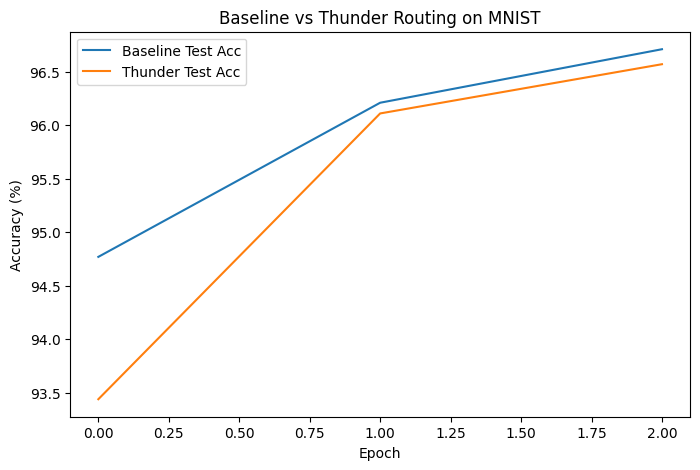

In [ ]:
# ==============================
# Thunder Routing vs Baseline NN
# ==============================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Dataset (MNIST)
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# -------------------------------
# Models
# -------------------------------
class BaselineNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x, return_actives=False):
        x = x.view(x.size(0), -1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        out = self.fc3(h2)
        if return_actives:
            return out, [h1>0, h2>0]
        return out

class ThunderNN(nn.Module):
    def __init__(self, k=100):  # top-k neurons
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.k = k

    def topk_activation(self, h):
        vals, idx = torch.topk(h, self.k, dim=1)
        mask = torch.zeros_like(h)
        mask.scatter_(1, idx, 1.0)
        return h * mask, mask

    def forward(self, x, return_actives=False):
        x = x.view(x.size(0), -1)
        h1 = F.relu(self.fc1(x))
        h1, m1 = self.topk_activation(h1)

        h2 = F.relu(self.fc2(h1))
        h2, m2 = self.topk_activation(h2)

        out = self.fc3(h2)
        if return_actives:
            return out, [m1, m2]
        return out

# -------------------------------
# Training & Evaluation
# -------------------------------
def train_model(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    all_preds, all_labels = [], []
    active_neurons_per_layer = []

    with torch.no_grad():
        start_time = time.time()
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs, actives = model(X, return_actives=True)

            loss = criterion(outputs, y)
            total_loss += loss.item() * X.size(0)

            preds = outputs.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            # Active neurons tracking
            batch_active = [a.sum().item() / X.size(0) for a in actives]
            active_neurons_per_layer.append(batch_active)

        end_time = time.time()

    acc = 100 * total_correct / total_samples
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")
    avg_loss = total_loss / total_samples
    avg_time = end_time - start_time
    avg_active = np.mean(active_neurons_per_layer, axis=0)

    return {
        "Accuracy": acc,
        "Loss": avg_loss,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "CompTime(s)": avg_time,
        "ActiveNeurons": avg_active
    }

# -------------------------------
# Run Experiment
# -------------------------------
def run_experiment(epochs=3):
    results = {}

    for name, model in [("Baseline", BaselineNN()), ("Thunder", ThunderNN(k=100))]:
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_losses, test_accs = [], []

        for epoch in range(epochs):
            train_loss = train_model(model, trainloader, criterion, optimizer, device)
            metrics = evaluate_model(model, testloader, criterion, device)

            train_losses.append(train_loss)
            test_accs.append(metrics["Accuracy"])

            print(f"[{name}] Epoch {epoch+1}/{epochs} | TrainLoss={train_loss:.4f} | TestAcc={metrics['Accuracy']:.2f}%")

        results[name] = {
            "FinalMetrics": metrics,
            "TrainLosses": train_losses,
            "TestAccs": test_accs
        }

    return results

# -------------------------------
# Run & Show Results
# -------------------------------
results = run_experiment(epochs=3)

print("\n=== Final Comparison ===")
for model, res in results.items():
    print(f"\n{model}:")
    for k, v in res["FinalMetrics"].items():
        if isinstance(v, np.ndarray):
            print(f"  {k}: {v.round(2)}")
        else:
            print(f"  {k}: {v}")

# Plot curves
plt.figure(figsize=(8,5))
for model, res in results.items():
    plt.plot(res["TestAccs"], label=f"{model} Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Baseline vs Thunder Routing on MNIST")
plt.show()
